# Project 3: Topic Classification using Naive Bayes

**Solution**

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

<span style="font-family:Verdana; color: green;">ANSWER: <br> The following snippet, prints (a) text of the message, and (b) the label (the name of the class) for the first 5 training examples.</span>

In [3]:
def Q1(num_examples=5):
    ### STUDENT START ###
    print("First 5 messages:")
    for i in range(5):
        print("Message ", i, ":")
        print(train_data[i])
        print("label: ", newsgroups_train.target_names[train_labels[i]])
        print("______________________________________________________________")
    ### STUDENT END ###

Q1(5)

First 5 messages:
Message  0 :
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
label:  comp.graphics
______________________________________________________________
Message  1 :


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

<span style="font-family:Verdana; color: green;">ANSWER: <br> In the following snippet we instantiate the CountVectorizer object. We use CountVectorizer to create feature vectors. We invoke fit_transform on the train data to vectorize. By default, CountVectorizer creates a word unigram vectors. There are 5 parts to this problem. We answer them in that order: </span>

<div style="font-family:Verdana; color: green;">
    <ol>
        <li>By default, CountVectorizer creates a word unigram vectors.
            <ol type="a">
                <li>The size of the vocabulary is second component of the shape tuple</li>
                <li>The average number of non-zero features (nnz) is the ratio of total nnz and number of training sample or document.</li>
                <li>The fraction of the non-zero entries (nnz) in the matrix is given by the ratio of nnz and the product of number of input samples and the size of the vocabulary.</li>
                <li>The 0th and last feature strings (in alphabetical order) is the 0th and last string the feature_names list. Though by defalut this is alphabatically order we have sorted just to be make sure they are indeed alphabatical.</li>
            </ol>
        </li>
        <li> To transform the training data into a matrix of word unigram feature vectors and restricting the vocabulary, we use the "vocabulary" param. As noted above word unigram is the default behavior. The average nnz is computed as above.
        </li>
        To transform the training data into a matrix of character bigram and trigram feature vectors, we use the params "ngram_range" and "analyzer".
        <li>
        To transform the training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents, we use the param "min_df".
        </li>
         <li>
          To calcualte the fraction of words in the development vocabulary that is missing from the training vocabulary we use the second component of the shape tuple of the dev and trainging datasets.
        </li>
    </ol>
</div>



In [4]:
def Q2():
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    feature_vectors = vectorizer.fit_transform(train_data)
    print('_______________________________________________________________________________________')
    print('Answers for Question 2.1:')
    print(' 2.1(A) The size of the vocabulary is {0}.'.format(feature_vectors.shape[1]))
    print(' 2.1(B) The average number of non-zero features per example is {0:.3f}.'
          .format(feature_vectors.nnz / float(len(train_data))))
    print(' 2.1(C) The fraction of non-zero entries in the matrix {0:.5f}'
          .format(float(feature_vectors.nnz) / (feature_vectors.shape[0] *feature_vectors.shape[1])))
    feature_strings = vectorizer.get_feature_names()
    feature_strings.sort()
    print(' 2.1(D) The 0th (1st) feature string is \"{0}\"'.format(feature_strings[0]))
    print(' 2.1(D) The last feature string is \"{0}\"'.format(feature_strings[-1]))
    print('_______________________________________________________________________________________')
    print('Answer for Question 2.2:')
    myownvocab = ["atheism", "graphics", "space", "religion"]
    countvec_myownvocab = CountVectorizer(vocabulary=myownvocab)
    feature_vectors_myownvocab = countvec_myownvocab.transform(raw_documents=train_data)
    print(' The size of the vocabulary after restricting the vocabulaory is {0}.'.format(feature_vectors_myownvocab.shape[1]))
    print(' The average number of non-zero features per example, when using a 4-word vocabulary, is {0:.3f}.'
          .format(feature_vectors_myownvocab.nnz / float(len(train_data))))
    print('_______________________________________________________________________________________')
    print('Answer for Question 2.3:')
    vect_char_ngram = CountVectorizer(analyzer='char', ngram_range=(2,3))
    feature_vectors_char_ngram = vect_char_ngram.fit_transform(raw_documents=train_data)
    print(' The size of the vocabulary with matrix of char & 2/3-gram feature vectors {0}.'.format(feature_vectors_char_ngram.shape[1]))
    print('_______________________________________________________________________________________')   
    print('Answer for Question 2.4:')
    vect_lt10 = CountVectorizer(min_df=10)
    feature_vectors_lt10 = vect_lt10.fit_transform(raw_documents=train_data)
    print(' The size of the vocabulary after prunning words less than 10 chars {0}.'.format(feature_vectors_lt10.shape[1]))
    print('_______________________________________________________________________________________')
    print('Answers for Question 2.5:')
    feature_vectors_dev = vectorizer.fit_transform(dev_data)
    print(' Difference in vocabulary sizes between dev and train data is {0:.3f}.'
          .format((feature_vectors.shape[1] - feature_vectors_dev.shape[1])/feature_vectors.shape[1]))
    print('_______________________________________________________________________________________')
    ### STUDENT END ###

Q2()

_______________________________________________________________________________________
Answers for Question 2.1:
 2.1(A) The size of the vocabulary is 26879.
 2.1(B) The average number of non-zero features per example is 96.706.
 2.1(C) The fraction of non-zero entries in the matrix 0.00360
 2.1(D) The 0th (1st) feature string is "00"
 2.1(D) The last feature string is "zyxel"
_______________________________________________________________________________________
Answer for Question 2.2:
 The size of the vocabulary after restricting the vocabulaory is 4.
 The average number of non-zero features per example, when using a 4-word vocabulary, is 0.268.
_______________________________________________________________________________________
Answer for Question 2.3:
 The size of the vocabulary with matrix of char & 2/3-gram feature vectors 35478.
_______________________________________________________________________________________
Answer for Question 2.4:
 The size of the vocabulary after 

https://github.com/juanjocarin/W207-Machine-Learning/blob/master/Juanjo_Carin_p2.ipynb?short_path=557ef69

### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

<span style="font-family:Verdana; color: green;">ANSWER: <br> In the following snippet we use the CountVectorizer to fit and transform training and dev data. Later, we fit the trained data using 3 models (a) KNN, (b) MultinomialNB, and LogisticRegression. We calculated the f1_score for each model by varying their respective hyper parameters. When we computed the f1_score across all models we used the weighted average method to compare them uniformly.</span>

<div style="font-family:Verdana; color: green;">
    <ol>
        <li>We transformed the training and development data to matrices of word unigram feature vectors.  It is important to note that CountVectorizer generates word unigram by default.</li>
        <li>We produced KNeighborsClassifier models for varying k and printed the f1-score for each model. </li>
        <li>We produced MultinomialNB models by varying smoothing (alpha) and printed the f1-score for each model.</li>
        <li>We produced LogisticRegression models with a liblinear solver by varying L2 regularization strength (C). We have printed the f1_score, and sum of squared weights for each model. When the training data size is small relative to the number of features, the information/data on prior probabilities help in improving the results in Naive Bayes models. In contrast, models like logistic regression tend to perform better when the number of samples are high compared to the number of features.</li>
        <li>In the KNeighborsClassifier, we first calcuate feature vectors for each document with the default "english" vocabulary. KNN operates on the basic premise of proximity. We pass feature vectors as input this model where each component in the vector is a tf(t,d) which is defined as the number of times a term t occurs in that document d. As this frequency vector doesn't correlate with the geometric proximity or hyper-space proximity, KNN model below tend to perform badly for this problem.</li>
        <li>The paper$^1$ refered below discusses the error properties of generative and discriminative models. This paper concludes that when the training size reaches infinity the discriminative models (e.g. logistic regression model) perform better than the generative models (e.g. Naive Bayes model). In our example above the the number of features is equal to 26879 and the number of samples is equal to 2034. Hence the Naive Bayes model performed better than the logistic regression model.</li>
        <li>In any regression probelm we try to minimize the error function for e.g. a squared error to arrive at a optimal solution. While we minimize the error we may not fit the training data well enough as we model may not generalize well as the coefficients of regression can become undesirably large. The idea of regularization is to avoid learning very large weights. We achive this by adding a penalty to the total size of the learned weights ($L_1$) or a squared weights ($L_2$). The $L_2$ regularization computes this size as the sum of the squared weights (as in Part 3 above). $L_1$ regularization computes this size as the sum of the absolute values of the weights. For e.g. $λ\sum_j \theta_j^2$, where  $λ$ is an arbitrary constant is called the regularization strength $L_2$ and the hyper parameter $C$ that we pass to the model in sklearn is what is called the inverse regularization strength $1/λ$ and values $θ_j^2$ are the squared coefficeint terms. </li>
   </ol>
</div>

<span style="font-family:Verdana; color: green;">References: </span>
1. http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf

In [5]:
def Q3():
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    feature_vectors_train = vectorizer.fit_transform(train_data)
    feature_vectors_dev = vectorizer.transform(dev_data)
    print(feature_vectors_train.shape)
    
    optimal_param = -1
    optimal_score = 0.0
    param = {'n_neighbors': np.concatenate([np.arange(1,10,1)]).tolist()}
    for n in param['n_neighbors']:
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(feature_vectors_train, train_labels)
        pred = knn.predict(feature_vectors_dev)
        score = metrics.f1_score(y_true=dev_labels, y_pred=pred, average='weighted')
        
        if optimal_score<score:
            optimal_param = n
            optimal_score = score
        #print(classification_report(pred, dev_labels))
        print('k is ', n, 'and f1-score is {0:.3f}'.format(score))
            
    print('optimal param & score: ', optimal_param, '{0:.3f}'.format(optimal_score))
    
    optimal_param = -1
    optimal_score = 0.0
    alpha = np.concatenate([np.arange(0.01,0.1,0.01), np.arange(0.1,1.1,0.1)])
    param = {'alpha': list(alpha)}
    for alpha in param['alpha']:
        nb_model = MultinomialNB(alpha=alpha)
        nb_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = nb_model.predict(feature_vectors_dev)
        score = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels, average='weighted')
        if optimal_score<score:
            optimal_param = alpha
            optimal_score = score
        #print(classification_report(pred, dev_labels))
        print('alpha is {0:.3f}'.format(alpha), 'and f1-score is {0:.3f}'.format(score))
    print('optimal param & score: ', optimal_param, '{0:.3f}'.format(optimal_score))


    optimal_param = -1
    optimal_score = 0.0
    inv_regul_str = np.concatenate([np.arange(0.1,0.5,0.02)])
    param = {'C': list(inv_regul_str)}
    for c in param['C']:
        Logit_model = LogisticRegression(penalty='l2', C=c, solver="liblinear", multi_class="auto")
        Logit_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
        score = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels, average='weighted')
        if optimal_score<score:
            optimal_param = c
            optimal_score = score
        #print(classification_report(pred, dev_labels))
        print('C is {0:.3f}'.format(c), ',f1-score is {0:.3f}'.format(score), 
              'and sum of squared weights is {0:.3f}'.format(np.sum(np.square(Logit_model.coef_))))
    print('optimal param & score: ', optimal_param, '{0:.3f}'.format(optimal_score))

    ### STUDENT END ###

Q3()

(2034, 26879)
k is  1 and f1-score is 0.381
k is  2 and f1-score is 0.381
k is  3 and f1-score is 0.408
k is  4 and f1-score is 0.403
k is  5 and f1-score is 0.429
k is  6 and f1-score is 0.447
k is  7 and f1-score is 0.450
k is  8 and f1-score is 0.447
k is  9 and f1-score is 0.437
optimal param & score:  7 0.450
alpha is 0.010 and f1-score is 0.775
alpha is 0.020 and f1-score is 0.783
alpha is 0.030 and f1-score is 0.783
alpha is 0.040 and f1-score is 0.784
alpha is 0.050 and f1-score is 0.786
alpha is 0.060 and f1-score is 0.786
alpha is 0.070 and f1-score is 0.786
alpha is 0.080 and f1-score is 0.788
alpha is 0.090 and f1-score is 0.790
alpha is 0.100 and f1-score is 0.790
alpha is 0.200 and f1-score is 0.788
alpha is 0.300 and f1-score is 0.788
alpha is 0.400 and f1-score is 0.788
alpha is 0.500 and f1-score is 0.786
alpha is 0.600 and f1-score is 0.786
alpha is 0.700 and f1-score is 0.785
alpha is 0.800 and f1-score is 0.785
alpha is 0.900 and f1-score is 0.781
alpha is 1.000 and

Hello


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|

|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|
(4, 4) (4,)


/Users/jagannathanlakshmipathy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.0, 0.4800000000000001)

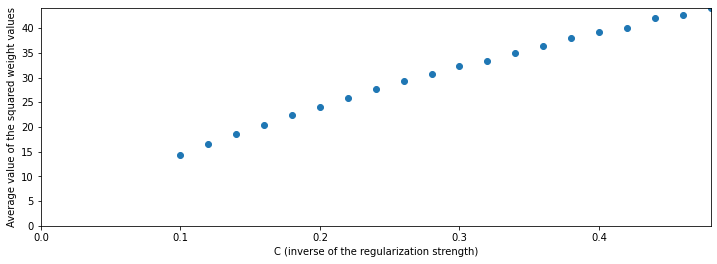

In [6]:
inv_regul_str = np.concatenate([np.arange(0.1,0.5,0.02)])

vectorizer = CountVectorizer()

print('Hello')

feature_vectors_train = vectorizer.fit_transform(train_data)
squared_sum = np.zeros(4*inv_regul_str.shape[0]).reshape(inv_regul_str.shape[0],4)

for i,c in enumerate(inv_regul_str):

    Logit_model = LogisticRegression(penalty='l2', C=c)
    Logit_model.fit(feature_vectors_train, train_labels)
    squared_sum[i,:] = np.square(Logit_model.coef_).sum(axis=1)
    squared_sum_short = squared_sum[4::5,:]
    inv_regul_str_short = inv_regul_str[4::5]
    classes = [c.rjust(18) for c in newsgroups_train.target_names]
    print("\n|      |{}|{}|{}|{}|".format(*classes))
table = []
print(squared_sum_short.shape, inv_regul_str_short.shape)
for i in range(10):
    #table.append([inv_regul_str_short[i], squared_sum_short[i,0], squared_sum_short [i,1],
                  #squared_sum_short [i,2], squared_sum_short [i,3]])
        pass
for i in table:
    print ("|{:6.2f}|{:18.4f}|{:18.4f}|{:18.4f}|{:18.4f}|".format(*i))
    "\n",
    "    # Another way of plotting the table, using matplotlib\n",
    "    # plt.figure(figsize=(10, 10))\n",
    "    # ax = plt.gca()\n",
    "    # ax.axes.get_xaxis().set_visible(False)\n",
    "    # ax.axes.get_yaxis().set_visible(False)\n",
    "    # ax.axis('off')\n",
    "    # table2 = plt.table(cellText=np.around(squared_sum_short, decimals=4),\n",
    "    #                    rowLabels=inv_regul_str_short,\n",
    "    #                    colLabels=newsgroups_train.target_names, loc='center')\n",
    "    # plt.show()\n",
    "\n",
    "    # Since the sum of the squared weight values is quite similar for each class, let's\n",
    "        # compare its average value (considering the 4 classes) to C, for each value of C\n",
squared_sum_mean = squared_sum[:,1:].mean(axis=1)
plt.figure(figsize=(12, 4))
plt.scatter(inv_regul_str, squared_sum_mean)
plt.xlabel("C (inverse of the regularization strength)")
plt.ylabel("Average value of the squared weight values")
plt.ylim([0, squared_sum_mean.max()])
plt.xlim([0, inv_regul_str.max()])

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


<span style="font-family:Verdana; color: green;">ANSWER: <br> In the following snippet we use the CountVectorizer to fit and transform dev data.</span>

<div style="font-family:Verdana; color: green;">
    <ol>
        <li>To transform the data to a matrix of word bigram feature vectors we have used "ngram_range" parameter</li>
        <li>To find the indices of 5 features with the largest weights we used the np.argpartition with -ve 5 as argument. And we use slicing to cut top 5 elements. We use argsort the those 5 elements. Finally we fetch the top 5 weights using np.take().</li>
        <li>Finally, we have shown a 20 row (features) x 4 column (topics) table of the weights.</li>
        <li>We observed several surprising features in the table.
            <ol type="a"> 
                <li> The bi-gram "the fbi" is classified more as a religious topic than atheistic topic.</li>
                <li> Bi-grams involving more mundane words like "and", "such", "but", "he" etc. have overwhelmingly selects a class. For e.g. consider the bi-grams "and such", "it was", and "but he"is classified more as a religious topic than atheistic topic. Can these frequent words be elimated? </li>
          </ol>
        </li>
   </ol>
</div>

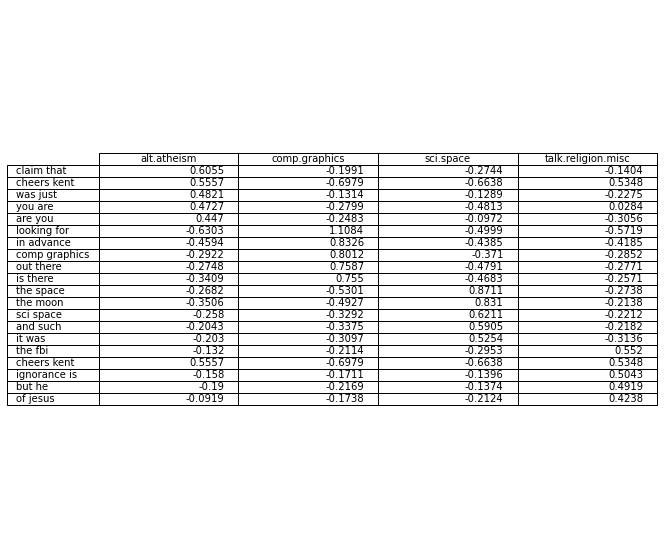

In [7]:
def Q4():
    ### STUDENT START ###
    def plot_table(CV):
        # transform train data
        feature_vectors = CV.fit_transform(raw_documents=train_data)
        
        #create a logit model with liblinear solver
        Logit_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
        
        #fit the model with the transformed train data
        Logit_model.fit(feature_vectors, train_labels)
        
        #find 5 features with the largest weights
        ind = np.argpartition(Logit_model.coef_, -5)[:,-5:]
        for i in range(len(newsgroups_train.target_names)):
            ind[i,:] = ind[i, np.argsort(np.take(Logit_model.coef_[i,:], ind[i,:]))[::-1]]
            
        
        ind = ind.flatten()
        weights = np.take(Logit_model.coef_, ind, axis=1).T
        word_features = CV.get_feature_names()
        main_features = np.empty(20).astype('str')
        for i in range(ind.shape[0]):
            main_features[i] = word_features[ind[i]].ljust(14)

        table = []
        for i in range(20):
            f = main_features[i]
            table.append([f, weights[i,0], weights[i,1], weights[i,2], weights[i,3]])

        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.axis('off')
        table2 = plt.table(cellText=np.around(weights, decimals=4),rowLabels=main_features, 
                           colLabels=newsgroups_train.target_names,loc='center')
        plt.show()
        
   
    plot_table(CountVectorizer(analyzer='word', ngram_range=(2,2)))
    ### STUDENT END ###

Q4()

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


<span style="font-family:Verdana; color: green;">ANSWER: <br> To improve generalization we tried several preprocessing methods. We tried transforming strings to lower case, removed punctuations, etc. While some of these approaches required some extra packages and libraries than those required for this project. We have attached the code as a raw text for the grader. However, our final and functinal code is provided in the code cell below.</span>

<span style="font-family:Verdana; color: green;">ANSWER: <br> In the following snippet we use the CountVectorizer to fit and transform dev data.</span>

<div style="font-family:Verdana; color: green;">
    <ol>
        <li>We produced a Logistic Regression model (with no preprocessing of text). We have overriden the "default" preprocessing with an identity function. We have evaluated and showed the f1 score and size of the dictionary.</li>
        <li>We then later produce an improved Logistic Regression model by preprocessing the text. We evaluated and showed its f1 score and size of the vocabulary. We got an improvement in f1 score of 0.02 with our best preprocessor.</li>
        <li>The improved model reduced the vocabulary size by 36152 (207578-171426).</li>
   </ol>
</div>

In [8]:
def my_default(doc):
    return(doc)

def best_preprocessor(text):
    text = text.lower()
    text = re.sub('\d+', 'NUM', text)
    text = re.sub('[^(a-zNUM)]', ' ', text)
    text = ' '.join([x[:5] for x in text.split()])
    return text

def Q5():
    ### STUDENT START ###
    def create_model(vectorizer):
        #transform train and dev data
        feature_vectors_train = vectorizer.fit_transform(train_data)
        feature_vectors_dev = vectorizer.transform(dev_data)
        
        #fit Logit model
        Logit_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
        Logit_model.fit(feature_vectors_train, train_labels)
        
        #predict on dev data
        dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
        
        #print vocab size and f1_score
        print('The size of the vocabulary is {0}.'.format(feature_vectors_dev.shape[1]))
        print('F1 score for a LogisticRegression classifier: {0:.2f}.'
              .format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels, average='weighted')))

    print("________________________DEFAULT PREPROCESSOR___________________________________")
    create_model(CountVectorizer(preprocessor=my_default, ngram_range=(2,2)))
    print("________________________BEST PREPROCESSOR____________________________________")
    create_model(CountVectorizer(preprocessor=best_preprocessor, ngram_range=(2,2)))
    ### STUDENT END ###

Q5()

________________________DEFAULT PREPROCESSOR___________________________________
The size of the vocabulary is 207578.
F1 score for a LogisticRegression classifier: 0.61.
________________________BEST PREPROCESSOR____________________________________
The size of the vocabulary is 171426.
F1 score for a LogisticRegression classifier: 0.63.


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

<span style="font-family:Verdana; color: green;">ANSWER: <br> In the following snippet we use the CountVectorizer to fit and transform dev data.</span>

<div style="font-family:Verdana; color: green;">
    <ol>
        <li>For several L1 regularization strengths ...
            <ol type="a">
                <li> We produced a Logistic Regression model using the $L_1$ regularization strength and reduced the vocabulary to only those features that have at least one non-zero weight for all the four categories.</li>
                <li>We produced a new Logistic Regression model using the reduced vocabulary . For this new model, we used the $L_2$ regularization strength of 0.5.</li>
                <li>We then evaluated the model with the dev data and showed the $L_1$ regularization strength, vocabulary size, and f1 score associated with the new model.</li>
            </ol>
        </li>
        <li>We have plotted f1 score vs. log vocabulary size for each $L_1$ regularization strength that used to reduce the vocabulary.</li>
        <li>We have plotted the f1 scores of all the 3 models against the reduced vocabulary. Performance of both the $L_2$ and $Relaxed$ models peaked when the regularization strength was at 0.5. $L_1$ model performance was going up and down as we scanned the regularization strength from 0.3 to 0.7.</li>
   </ol>
</div>


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Reg. strength: 1000.00 Reduced Voc. Sz: 26876 L2 F1 Score: 0.69
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Reg. strength: 100.00 Reduced Voc. Sz: 26868 L2 F1 Score: 0.71
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Reg. strength: 33.33 Reduced Voc. Sz: 26852 L2 F1 Score: 0.70
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Reg. strength: 20.00 Reduced Voc. Sz: 26834 L2 F1 Score: 0.70
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Reg. strength: 10.00 Reduced Voc. Sz: 26813 L2 F1 Score: 0.68
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Reg. strength: 3.33 Reduced Voc. Sz: 26710 L2 F1 Score: 0.69
[[0. 0. 0. ... 0. 0.

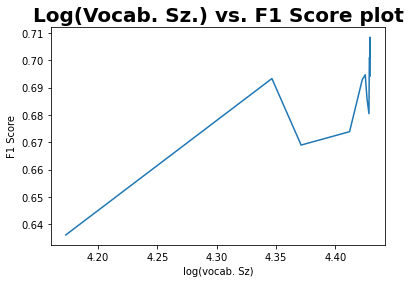

In [30]:
def Q6():
    ### STUDENT START ###
    def create_table(vectorizer, ci):
        np.random.seed(0)
        feature_vectors_train = vectorizer.fit_transform(train_data)
        feature_vectors_dev = vectorizer.transform(dev_data)
        
        metrics_map = {}
        Logit_model1 = LogisticRegression(C=ci, solver="liblinear", penalty="l1",  tol=0.015)
        Logit_model1.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = Logit_model1.predict(feature_vectors_dev)
        #recording the L1 reg. strength, voc size, and F1 score 
        metrics_map['Reg. Strength'] =  ci
        metrics_map['Voc. Size'] =  feature_vectors_dev.shape[1]
        metrics_map['L1 F1'] = metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels, average='weighted')
        
        #Filter unimportant features and record the size of reduced feature size
        #recording the reduced voc. Size 
        flags1 = np.sum(Logit_model1.coef_, axis=0)
        
        flags1 = flags1 >= 0
        print(Logit_model1.coef_)
        feature_vectors_train_reduced = feature_vectors_train[:, flags1]
        feature_vectors_dev_reduced = feature_vectors_dev[:, flags1]
        metrics_map['reduced voc. Size'] =  feature_vectors_dev_reduced.shape[1]
        
        #Create Logit model with L2 regularization of 0.5
        #recording the 'L2 F1' score
        Logit_model2 = LogisticRegression(C=0.5, solver="liblinear",  penalty="l2",  tol=0.015)
        Logit_model2.fit(feature_vectors_train_reduced, train_labels)
        dev_reduced_predicted_labels = Logit_model2.predict(feature_vectors_dev_reduced)
        metrics_map['L2 F1'] = metrics.f1_score(y_true=dev_labels, y_pred=dev_reduced_predicted_labels, average='weighted')
        
        #Created a relaxed Logit model
        #Logit_model3 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto",  tol=0.015)
        #Logit_model3.fit(feature_vectors_train_reduced, train_labels)
        #dev_reduced_predicted_labels = Logit_model3.predict(feature_vectors_dev_reduced)
        #metrics_map['relaxed F1'] = metrics.f1_score(y_true=dev_labels, y_pred=dev_reduced_predicted_labels, average='weighted')
        return metrics_map
    
    x = []
    y1 = []
    y2 = []
    y3 = []
    #for ci in np.arange(0.3, 0.75, 0.05):
    for ci in [0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 10, 50, 100, 1000]:
        m = create_table(CountVectorizer(), ci)
        print('Reg. strength: {0:.2f}'.format(m['Reg. Strength']), 
              'Reduced Voc. Sz: {}'.format(m['reduced voc. Size']), 
              'L2 F1 Score: {0:.2f}'.format(m['L2 F1']))
        x.append(np.log10(m['reduced voc. Size']))
        y1.append(m['L2 F1'])
        y2.append(m['L1 F1'])
        #y3.append(m['relaxed F1'])

    plt.plot(x, y1)
    #plt.plot(x, y2)
    #plt.plot(x, y3)
    #plt.legend(["L2 F1", "L1 F1"])
    plt.xlabel("log(vocab. Sz)")
    plt.ylabel("F1 Score")
    plt.title('Log(Vocab. Sz.) vs. F1 Score plot',fontweight ="bold", fontsize=20)
    ### STUDENT END ###

Q6()

In [23]:
np.log10(26876)

4.429364632417697

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

<span style="font-family:Verdana; color: green;">ANSWER: <br> Here we produced a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100. We then evaluated and showed the f1 score.</span>

<div style="font-family:Verdana; color: green;">
    <ol>
        <li>Both TfidVectorizer and CountVectorizer convert a collection of text documents to vectors of numbers. If no prior dictionary and/or an analyzer is provided the features selected by the vectorizer will be equal to the vocabulary size. If a dictionary or a analyzer are provided as input then the vector is constrained to match the inputs. TfidVectorizer and CountVectorizer differ as follows:</li>
            <ol type="a">
                <li>CountVectorizer counts the frequency of all words in our corpus, sorts them and grabs the most recurring features (using max_features hyperparameter). But these results are mostly biased and our model might loose out on some of the important less frequent features</li>
                <li>TfidVectorizer computes a product of tf(t,d) (Term Frequency) and idf(t,d) (Inverse Document Frequency), where idf(t,d) is defined as $log \frac{n_d}{1+df(d,t)}$, where df(d,t) is the number of documents d that contain the term t and $n_d$ is the total number of documents and tf(t,d) is defined as the number of times a term t occurs in a docuemnt d.</li>
            </ol>
        <li>In the following snippet we have Showed 3 documents with highest R ratio as defined above.</li>
        <li>As defined above, the R ratio is a ratio of maximum predicted and predicted probability of correct label. As the model predicts the label with the highest probability the R ratio will be 1 only when the model is correctly predicted else the ratio will be higher than 1.0</li>
        <li>In the following snippet we have Showed 3 documents with highest R ratio as defined above.</li>
   </ol>
</div>

Accuracy for a Logistic Regression classifier using TfidfVectorizer: 76.33%
Percentage of incorrectly predicted labels (R>1): 23.67% (=1-Accuracy)\n
--------------------------------------------------------
216th DOCUMENT: R = 929.36
* PREDICTED CATEGORY (prob = 0.9937): comp.graphics
* CORRECT CATEGORY   (prob = 0.0011): talk.religion.misc\n
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, b

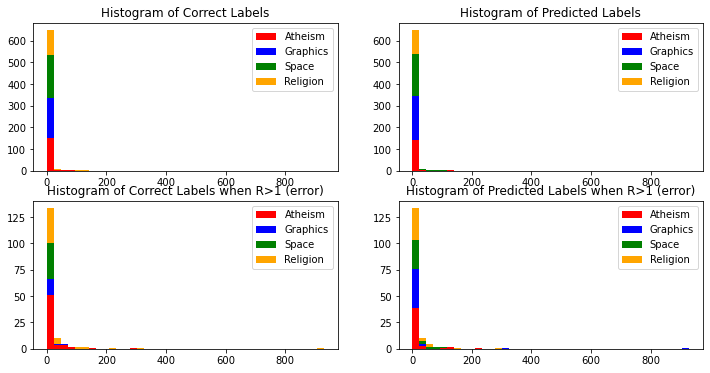

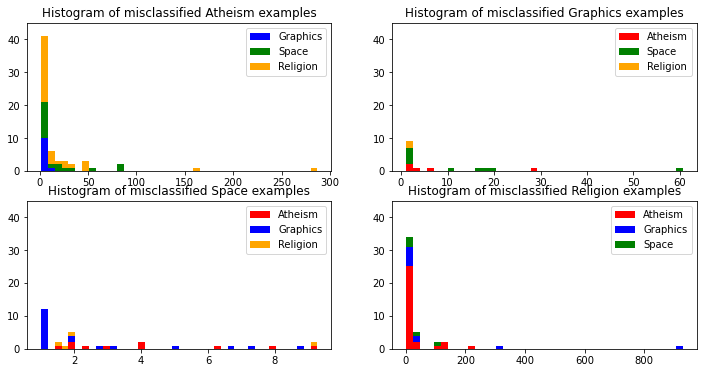

In [59]:
def Q7():
    ### STUDENT START ###
    TFIDF = TfidfVectorizer()
    feature_vectors_train = TFIDF.fit_transform(raw_documents=train_data)
    Logit_model = LogisticRegression(penalty='l2', C = 100, solver="liblinear", multi_class="auto")
    Logit_model.fit(feature_vectors_train, train_labels)
    feature_vectors_dev = TFIDF.transform(raw_documents=dev_data)
    dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
    print('Accuracy for a Logistic Regression classifier using TfidfVectorizer: {0:.2f}%'.
          format(100*metrics.accuracy_score(y_true=dev_labels, y_pred=dev_predicted_labels)))
    dev_Probs = Logit_model.predict_proba(feature_vectors_dev)
    max_Prob = dev_Probs.max(axis=1)
    Prob_correct_label = np.array([dev_Probs[i,j] for i,j in zip(range(len(dev_labels)),dev_labels)])
    R = max_Prob / Prob_correct_label
    print('Percentage of incorrectly predicted labels (R>1): {0:.2f}% (=1-Accuracy)\\n'.
          format(100*len(R[R>1])/float(len(R))))
    
    doc_index = np.argpartition(R, -3)[-3:]
    doc_index = doc_index[np.argsort(R[doc_index])][::-1]
    for i,ind in enumerate(doc_index):
        print('--------------------------------------------------------')
        print('{0}th DOCUMENT: R = {1:.2f}'.format(ind+1, R[ind]))
        print('* PREDICTED CATEGORY (prob = {0:.4f}): {1}'
              .format(max_Prob[ind], newsgroups_train.target_names[dev_Probs[ind,:].argmax()]))
        print('* CORRECT CATEGORY   (prob = {0:.4f}): {1}\\n'
              .format(dev_Probs[ind,dev_labels[ind]],newsgroups_train.target_names[dev_labels[ind]]))
        print(dev_data[ind])
        
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    atheism = R[(dev_labels==0)]
    graphics = R[(dev_labels==1)]
    space = R[(dev_labels==2)]
    religion = R[(dev_labels==3)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels')
    
    ax = plt.subplot(2, 2, 2)
    pred_atheism = R[(dev_predicted_labels==0)]
    pred_graphics = R[(dev_predicted_labels==1)]
    pred_space = R[(dev_predicted_labels==2)]
    pred_religion = R[(dev_predicted_labels==3)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels')
    
    ax = plt.subplot(2, 2, 3)
    atheism = R[(dev_labels==0) & (R>1)]
    graphics = R[(dev_labels==1) & (R>1)]
    space = R[(dev_labels==2) & (R>1)]
    religion = R[(dev_labels==3) & (R>1)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels when R>1 (error)')
    ax = plt.subplot(2, 2, 4)
    pred_atheism = R[(dev_predicted_labels==0) & (R>1)]
    pred_graphics = R[(dev_predicted_labels==1) & (R>1)]
    pred_space = R[(dev_predicted_labels==2) & (R>1)]
    pred_religion = R[(dev_predicted_labels==3) & (R>1)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels when R>1 (error)')
    atheism_graphics = R[(dev_labels==0) & (dev_predicted_labels==1)]
    atheism_space = R[(dev_labels==0) & (dev_predicted_labels==2)]
    atheism_religion = R[(dev_labels==0) & (dev_predicted_labels==3)]
    graphics_atheism = R[(dev_labels==1) & (dev_predicted_labels==0)]
    graphics_space = R[(dev_labels==1) & (dev_predicted_labels==2)]
    graphics_religion = R[(dev_labels==1) & (dev_predicted_labels==3)]
    space_atheism = R[(dev_labels==2) & (dev_predicted_labels==0)]
    space_graphics = R[(dev_labels==2) & (dev_predicted_labels==1)]
    space_religion = R[(dev_labels==2) & (dev_predicted_labels==3)]
    religion_atheism = R[(dev_labels==3) & (dev_predicted_labels==0)]
    religion_graphics = R[(dev_labels==3) & (dev_predicted_labels==1)]
    religion_space = R[(dev_labels==3) & (dev_predicted_labels==2)]
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    plt.hist([atheism_graphics,atheism_space,atheism_religion], 40, stacked=True, color=['blue','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Graphics','Space','Religion'])
    plt.title('Histogram of misclassified ''Atheism'' examples')
    ax = plt.subplot(2, 2, 2)
    plt.hist([graphics_atheism,graphics_space,graphics_religion], 40, stacked=True, color=['red','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Space','Religion'])
    plt.title('Histogram of misclassified ''Graphics'' examples')
    ax = plt.subplot(2, 2, 3)
    plt.hist([space_atheism,space_graphics,space_religion], 40, stacked=True, color=['red','blue','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Religion'])
    plt.title('Histogram of misclassified ''Space'' examples')
    ax = plt.subplot(2, 2, 4)
    plt.hist([religion_atheism,religion_graphics,religion_space], 40, stacked=True, color=['red','blue','green'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Space'])
    plt.title('Histogram of misclassified ''Religion'' examples')
    ### STUDENT END ###

Q7()

ANSWER: 

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

Accuracy for a Logistic Regression classifier using TfidfVectorizer: 76.48%
Percentage of incorrectly predicted labels (R>1): 23.52% (=1-Accuracy)\n
--------------------------------------------------------
216th DOCUMENT: R = 1376.65
* PREDICTED CATEGORY (prob = 0.9939): comp.graphics
* CORRECT CATEGORY   (prob = 0.0007): talk.religion.misc\n
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, 

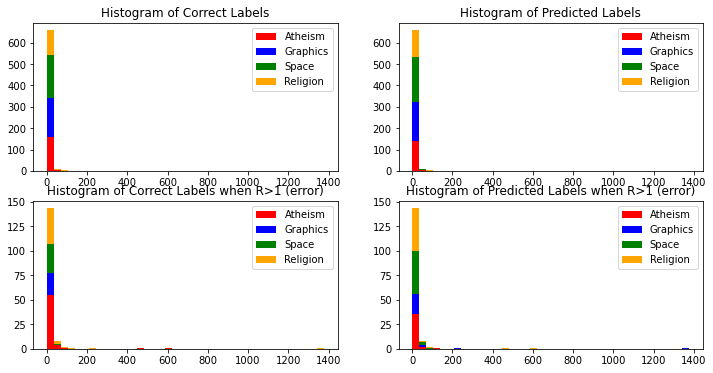

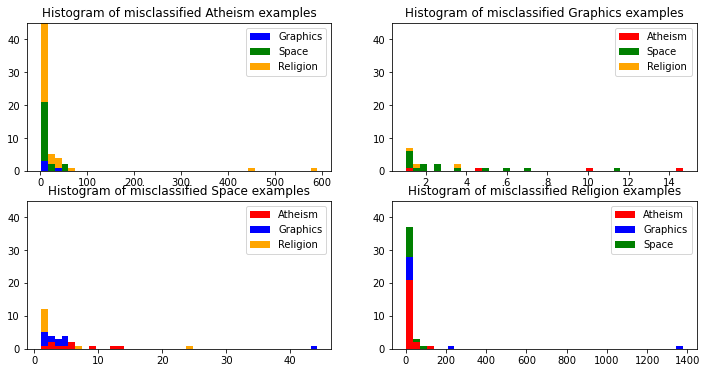

In [60]:
def remove_punct(s):
    #print(string.punctuation)
    #table = str.maketrans("", "", string.punctuation)
    #table = str.maketrans("", "", "\'")
    #return s.translate(table)
    #words = nltk.word_tokenize(s)
    #words=[word.lower() for word in words if word.isalpha()]
    #return " ".join(words)
    return s.translate(str.maketrans('', '', string.punctuation))

def better_preprocessor(text):
    #text = remove_URL(text)
    #text = remove_html(text)
    #text = remove_emoji(text)
    #text = remove_punct(text)
    #text = stemming(text)
    #text = remove_stopwords(text)
    return text

def better_preprocessor1(text):
    text = text.lower()
    text = re.sub('\d+', 'NUM', text)
    text = re.sub('[^(a-zNUM)]', ' ', text)
    text = ' '.join([x[:5] for x in text.split()])
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_punct(text)
    return text

def Q8():
    ### STUDENT START ###
    TFIDF = TfidfVectorizer(stop_words=stopwords.words('english'), preprocessor=better_preprocessor1)
    feature_vectors_train = TFIDF.fit_transform(raw_documents=train_data)
    Logit_model = LogisticRegression(penalty='l2', C = 100, solver="liblinear", multi_class="auto")
    Logit_model.fit(feature_vectors_train, train_labels)
    feature_vectors_dev = TFIDF.transform(raw_documents=dev_data)
    dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
    print('Accuracy for a Logistic Regression classifier using TfidfVectorizer: {0:.2f}%'.
          format(100*metrics.accuracy_score(y_true=dev_labels, y_pred=dev_predicted_labels)))
    dev_Probs = Logit_model.predict_proba(feature_vectors_dev)
    max_Prob = dev_Probs.max(axis=1)
    Prob_correct_label = np.array([dev_Probs[i,j] for i,j in zip(range(len(dev_labels)),dev_labels)])
    R = max_Prob / Prob_correct_label
    print('Percentage of incorrectly predicted labels (R>1): {0:.2f}% (=1-Accuracy)\\n'.
          format(100*len(R[R>1])/float(len(R))))
    
    doc_index = np.argpartition(R, -3)[-3:]
    doc_index = doc_index[np.argsort(R[doc_index])][::-1]
    for i,ind in enumerate(doc_index):
        print('--------------------------------------------------------')
        print('{0}th DOCUMENT: R = {1:.2f}'.format(ind+1, R[ind]))
        print('* PREDICTED CATEGORY (prob = {0:.4f}): {1}'
              .format(max_Prob[ind], newsgroups_train.target_names[dev_Probs[ind,:].argmax()]))
        print('* CORRECT CATEGORY   (prob = {0:.4f}): {1}\\n'
              .format(dev_Probs[ind,dev_labels[ind]],newsgroups_train.target_names[dev_labels[ind]]))
        print(dev_data[ind])
        
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    atheism = R[(dev_labels==0)]
    graphics = R[(dev_labels==1)]
    space = R[(dev_labels==2)]
    religion = R[(dev_labels==3)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels')
    
    ax = plt.subplot(2, 2, 2)
    pred_atheism = R[(dev_predicted_labels==0)]
    pred_graphics = R[(dev_predicted_labels==1)]
    pred_space = R[(dev_predicted_labels==2)]
    pred_religion = R[(dev_predicted_labels==3)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels')
    
    ax = plt.subplot(2, 2, 3)
    atheism = R[(dev_labels==0) & (R>1)]
    graphics = R[(dev_labels==1) & (R>1)]
    space = R[(dev_labels==2) & (R>1)]
    religion = R[(dev_labels==3) & (R>1)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels when R>1 (error)')
    ax = plt.subplot(2, 2, 4)
    pred_atheism = R[(dev_predicted_labels==0) & (R>1)]
    pred_graphics = R[(dev_predicted_labels==1) & (R>1)]
    pred_space = R[(dev_predicted_labels==2) & (R>1)]
    pred_religion = R[(dev_predicted_labels==3) & (R>1)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels when R>1 (error)')
    atheism_graphics = R[(dev_labels==0) & (dev_predicted_labels==1)]
    atheism_space = R[(dev_labels==0) & (dev_predicted_labels==2)]
    atheism_religion = R[(dev_labels==0) & (dev_predicted_labels==3)]
    graphics_atheism = R[(dev_labels==1) & (dev_predicted_labels==0)]
    graphics_space = R[(dev_labels==1) & (dev_predicted_labels==2)]
    graphics_religion = R[(dev_labels==1) & (dev_predicted_labels==3)]
    space_atheism = R[(dev_labels==2) & (dev_predicted_labels==0)]
    space_graphics = R[(dev_labels==2) & (dev_predicted_labels==1)]
    space_religion = R[(dev_labels==2) & (dev_predicted_labels==3)]
    religion_atheism = R[(dev_labels==3) & (dev_predicted_labels==0)]
    religion_graphics = R[(dev_labels==3) & (dev_predicted_labels==1)]
    religion_space = R[(dev_labels==3) & (dev_predicted_labels==2)]
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    plt.hist([atheism_graphics,atheism_space,atheism_religion], 40, stacked=True, color=['blue','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Graphics','Space','Religion'])
    plt.title('Histogram of misclassified ''Atheism'' examples')
    ax = plt.subplot(2, 2, 2)
    plt.hist([graphics_atheism,graphics_space,graphics_religion], 40, stacked=True, color=['red','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Space','Religion'])
    plt.title('Histogram of misclassified ''Graphics'' examples')
    ax = plt.subplot(2, 2, 3)
    plt.hist([space_atheism,space_graphics,space_religion], 40, stacked=True, color=['red','blue','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Religion'])
    plt.title('Histogram of misclassified ''Space'' examples')
    ax = plt.subplot(2, 2, 4)
    plt.hist([religion_atheism,religion_graphics,religion_space], 40, stacked=True, color=['red','blue','green'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Space'])
    plt.title('Histogram of misclassified ''Religion'' examples')
    ### STUDENT END ###

Q8()

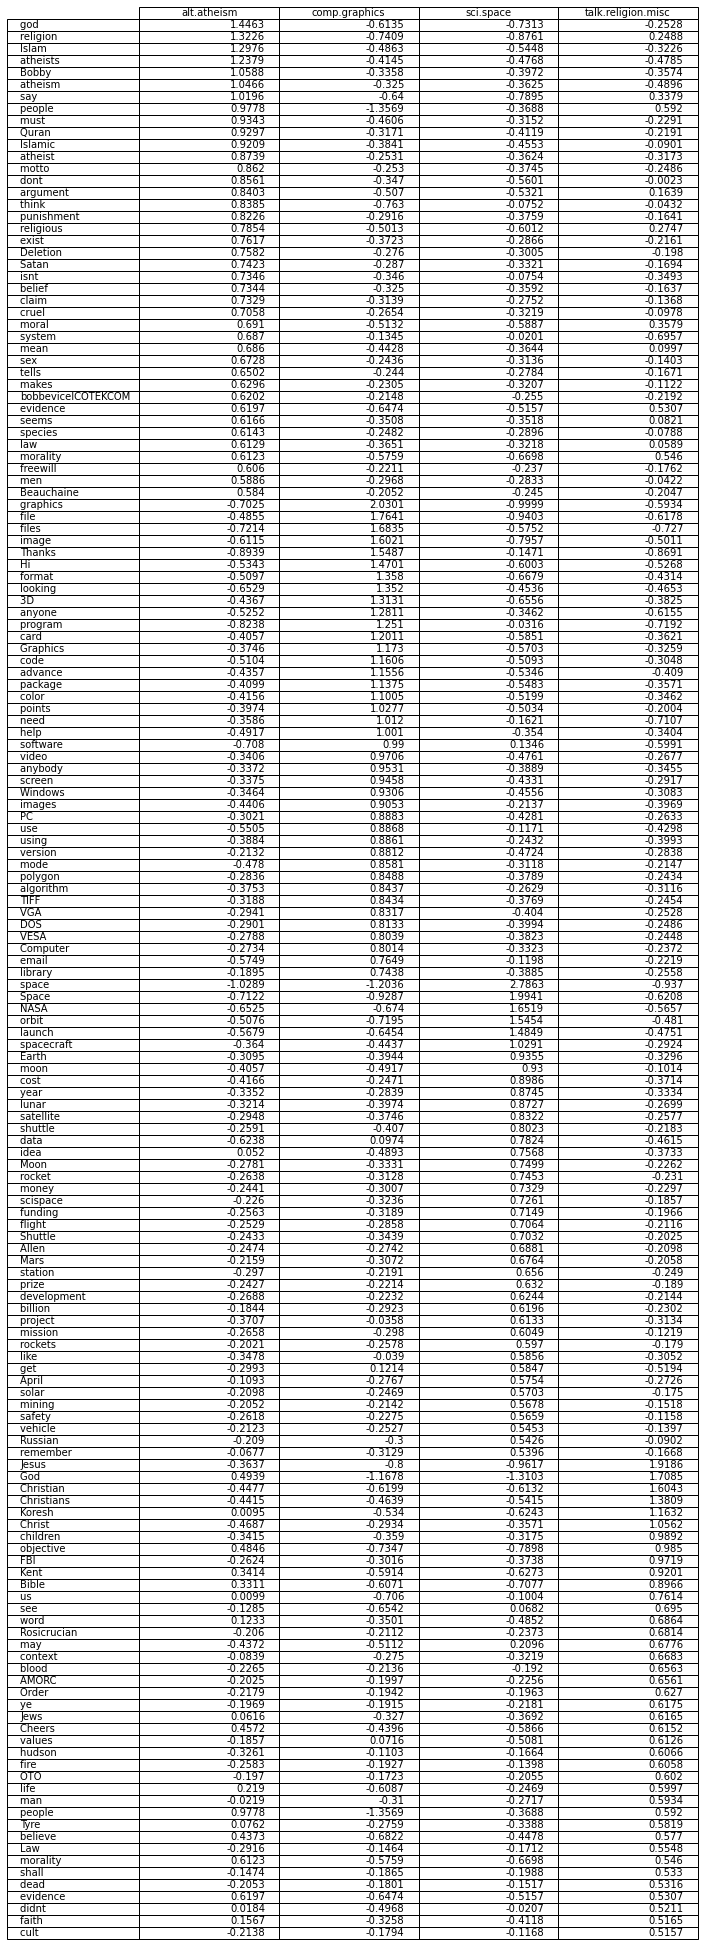

In [61]:
def remove_punct(s):
    #print(string.punctuation)
    #table = str.maketrans("", "", string.punctuation)
    #table = str.maketrans("", "", "\'")
    #return text.translate(table)
    #words = nltk.word_tokenize(s)
    #words=[word.lower() for word in words if word.isalpha()]
    #return " ".join(words)
    return s.translate(str.maketrans('', '', string.punctuation))

def better_preprocessor(text):
    #text = remove_URL(text)
    #text = remove_html(text)
    text = remove_emoji(text)
    text = remove_punct(text)
    #text = stemming(text)
    text = remove_stopwords(text)
    return text

TFIDF = TfidfVectorizer(preprocessor=better_preprocessor)
feature_vectors = TFIDF.fit_transform(raw_documents=train_data)
n = 40

Logit_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
Logit_model.fit(feature_vectors, train_labels)
ind = np.argpartition(Logit_model.coef_, -n)[:,-n:]
for i in range(len(newsgroups_train.target_names)):
    ind[i,:] = ind[i, np.argsort(np.take(Logit_model.coef_[i,:], ind[i,:]))[::-1]]
ind = ind.flatten()
weights = np.take(Logit_model.coef_, ind, axis=1).T
word_features = TFIDF.get_feature_names()
main_features = np.empty(n*4).astype('str')
for i in range(ind.shape[0]):
    main_features[i] = word_features[ind[i]].ljust(14)

table = []
for i in range(n*4):
    f = main_features[i]
    table.append([f, weights[i,0], weights[i,1], weights[i,2], weights[i,3]])
    
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axis('off')
table2 = plt.table(cellText=np.around(weights, decimals=4),rowLabels=main_features, colLabels=newsgroups_train.target_names,loc='center')
plt.show()

In [62]:
s = "Mormon_ _Mormon's string. With. with_ \"hell.\" Punctuation?"
s.translate(str.maketrans('', '', string.punctuation))

'Mormon Mormons string With with hell Punctuation'

In [63]:
from sklearn.model_selection import train_test_split
import time

def train(classifier, X_train, y_train, X_test, y_test):
    start = time.time()
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

    classifier.fit(X_train, y_train)
    end = time.time()

    print("Accuracy: " + str(classifier.score(X_test, y_test)) + ", Time duration: " + str(end - start))
    return classifier

In [64]:
for alpha in [5, 0.5, 0.05, 0.005, 0.0005]:
    trial3 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', MultinomialNB(alpha=alpha))])


    train(trial3, train_data, train_labels, test_data, test_labels)

Accuracy: 0.6942392909896603, Time duration: 0.21326684951782227
Accuracy: 0.7562776957163959, Time duration: 0.20815515518188477
Accuracy: 0.8005908419497785, Time duration: 0.2108139991760254
Accuracy: 0.7917282127031019, Time duration: 0.20719003677368164
Accuracy: 0.7917282127031019, Time duration: 0.21021223068237305


In [65]:
for ci in np.arange(100, 500, 3):
    trial3 = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),('classifier', LogisticRegression(penalty='l2', C = ci, solver="liblinear", multi_class="auto"))])

train(trial3, train_data, train_labels, test_data, test_labels)

Accuracy: 0.7858197932053176, Time duration: 0.31506896018981934


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier', LogisticRegression(C=499, solver='liblinear'))])